<h1 style="font-size:30px;">Detector NN-Architecture</h1>


In this unit, let’s study the detector network architecture in detail.


|<img src='https://opencv.org/wp-content/uploads/2022/06/object_detection_model.png' width=800, > | <img src='https://opencv.org/wp-content/uploads/2022/06/pipeline_config_v3.png'  width=860>|
|-|-|


## Table of Contents


- [1 Why to Use Feature Pyramid Network, FPN](#1-Why-to-Use-Feature-Pyramid-Network,-FPN)
- [2 The Detector Architecture](2-The-Detector-Architecture)
- [3 A Sample Inference](3-A-Sample-Inference)

## 1 Why to Use Feature Pyramid Network, FPN

Here, we will use the [Feature Pyramid Network](https://arxiv.org/pdf/1612.03144.pdf) for feature extraction. Above this, we will also use class subnet and box subnet to get classification and to get the bounding boxes respectively. Have a look at its architecture:


Feature Pyramid Net is built on top of ResNet (we will use `ResNet-18`) in a fully convolutional fashion.
It includes two pathways: 
- **bottom-up or forward**
- **top-down**, which goes in the inverse direction. 

Lateral connections link up the two pathways.


Bottom-up pathway follows  the feedforward path, and goes about extracting the features. Nothing new here.


**What about the top-down pathway?**

Features closer to the input image have rich segment (bounding box) information. So we need to merge all the feature maps from different levels of the pyramid into one semantically-rich feature map.

**Look closely at the top-down and lateral connection (the right figure).**

|<img src='https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w8-retinanet.png' width=1350>|<img src='https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w8-lateral_con.png' width=500>|
|-|-|

In [ ]:
# required imports
import os
import requests
from zipfile import ZipFile
import tensorflow as tf

### Download Dependencies

Let's download scripts (for model architecture), model (the resent-18 backbone weights), and a few sample images. 

**The below code cell has a method for downloading a file.**

In [ ]:
def download_file(url, save_name):
    """
    "Download and save the file."

    arguments:
    url (str): URL path of the file.
    save_name: (str): file path to save the downloaded file.
    """
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)
    print(f"Downloaded {save_name}...")
    return

**The below method can use to unzip a zipped file.**

In [ ]:
def unzip(zip_file_path=None):
    """
    "Unzip the file"

    arguments:
    zip_file_path (str): The zipped file path

    """
    try:
        with ZipFile(zip_file_path) as z:
            z.extractall("./")
            print(f"Extracted {zip_file_path}...\n")
    except:
        print("Invalid file")

    return

**Download and unzip the required files.**

In [ ]:
if not os.path.exists('models'):
    download_file(
                  'https://www.dropbox.com/s/bqedbdn58sw5dl5/detector_nn_architecture.zip?dl=1',
                  'detector_nn_architecture.zip'
                 )
    
    unzip('detector_nn_architecture.zip')

Downloaded detector_nn_architecture.zip...
Extracted detector_nn_architecture.zip...



After downloading and unzipping, the following folders and files should be there:

**folders:** `test_images` and `models`

**files:** `detector.py` and `fpn.py`

Let's very it by running the below cell. 

In [ ]:
os.listdir("./")

['.config',
 'detector.py',
 'models',
 'test_images',
 'detector_nn_architecture.zip',
 'fpn.py',
 'sample_data']

## 2 The Detector Architecture

The method `get_detector` is defined in `detector.py`. It takes the following arguments:

- `input_shape (tuple)`: The default input shape is `(300, 300, 3)`. 
- `backbone_name (str)`: `resnet_18` or `resnet_50`. Default is `resnet_18`.
- `num_classes (int)`: Number of classes. Default is `2`.
- `fpn_channels (int)`: Number of FPN filters. Default is `32`.
- `num_anchors (int)`: Number of anchors. Default is `9`.

It returns a Keras model that has two output heads (`classification` and `localization`)

In [ ]:
from detector import get_detector

In [ ]:
input_shape = (300, 300, 3)
backbone_name = "resnet_18"
num_classes = 2
fpn_channels = 32
num_anchors = 9

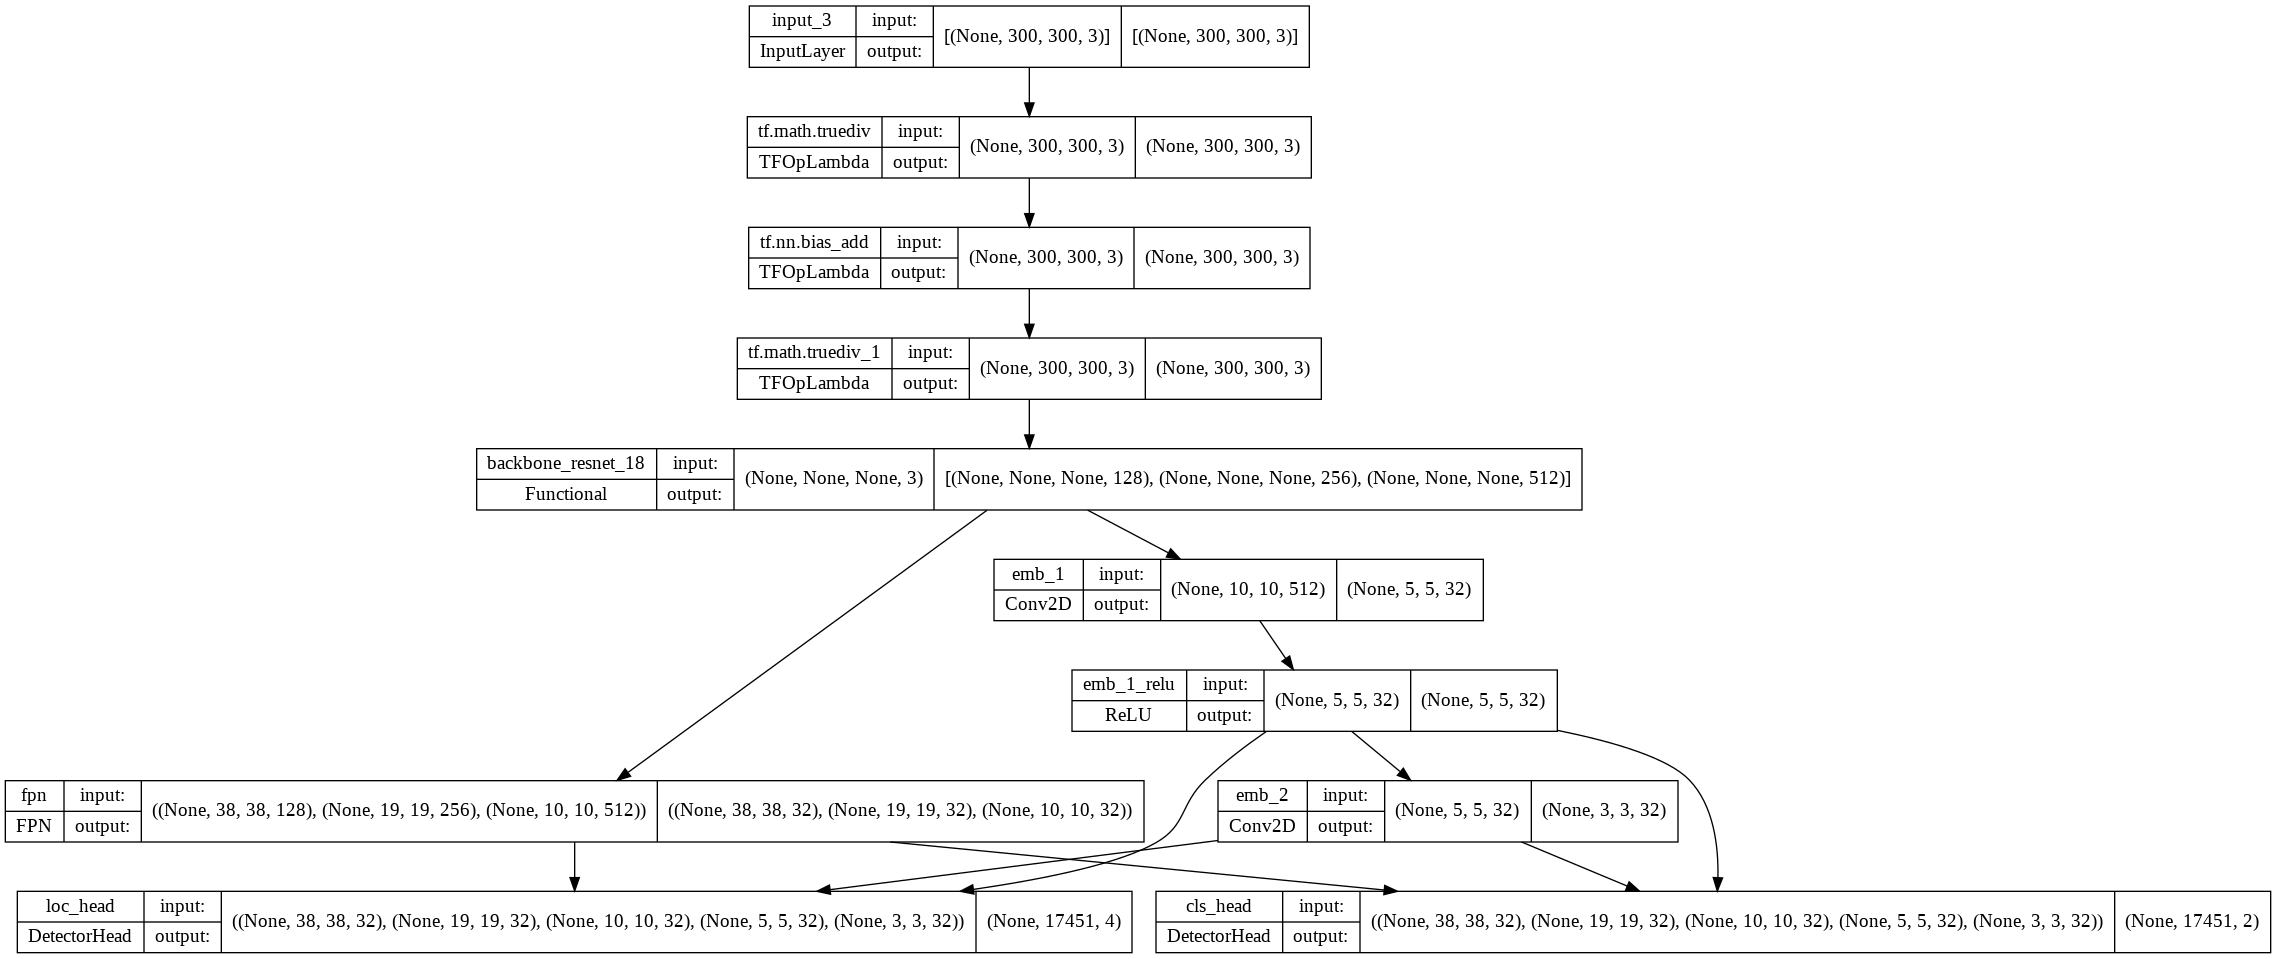

In [ ]:
detector = get_detector(
    input_shape=input_shape,
    backbone_name=backbone_name,
    num_classes=num_classes,
    fpn_channels=fpn_channels,
    num_anchors=num_anchors
)

# Plot the detector model
tf.keras.utils.plot_model(detector, to_file='detector.png', show_shapes=True, rankdir='TB')

**In case you are wondering about the inputs and output shape of loc_head and cls_head.**

**For example:**


The inputs shapes of `loc_head` (`DetectorHead`):
```
(None, 38, 38, 32)   # FPN output 1 / input 1
(None, 19, 19, 32)   # FPN output 2 / input 2
(None, 10, 10, 32)   # FPN output 3 / input 3
(None, 5, 5, 32)     # emb_1 output / input 4
(None, 3, 3, 32)     # emb_2 output / input 5

```

The output shape of `loc_head` (`DetectorHead`):
```
(None, 17451, 4)    # loc_head output
```

Let's look at the `_make_head` method in `DetectorHead` `class` responsible for localization (`loc_head`) and classification (`cls_head`) head.

Here, `output_filters` for `loc_head` is `(num_anchors x 4)` and for `cls_head` is `(num_anchors x num_class)`. 

```python
class DetectorHead(Layer):
    .
    .
    @staticmethod
    def _make_head(fpn_channels, output_filters, **kwargs):

        head = Sequential([InputLayer(input_shape=[None, None, fpn_channels])], **kwargs)

        for _ in range(4):
            head.add(Conv2D(fpn_channels, 3, padding="same"))
            head.add(ReLU())

        head.add(Conv2D(output_filters, 3, 1, padding="same"))
        return head
```

If we use the above model and `num_anchors` is `9`, the output channel for `loc_head` will be (`9 x 4 = 36`).

So the following are the input-output pairs.

|`input`|`output`|
|-|-|
|`(None, 38, 38, 32)`|`(None, 38, 38, 36)`|
|`(None, 19, 19, 32)`|`(None, 19, 19, 36)`|
|`(None, 10, 10, 32)`|`(None, 10, 10, 36)`|
|`(None, 5, 5, 32)`|`(None, 5, 5, 36)`|
|`(None, 3, 3, 32)`|`(None, 3, 3, 36)`|


Each output of `loc_head` is reshaped using the following method:
```python
tf.reshape(pred, [-1, pred.shape[1] * pred.shape[2] * num_anchors, 4])
```

And the output of `cls_head` is reshaped using the following method:
```python
tf.reshape(pred, [-1, pred.shape[1] * pred.shape[2] * num_anchors, num_classes])
```

Finally, all reshaped tensors are stacked together along `1-axis`.

So the final output shape for `loc_head` is the following:

```
(None, 38*38*9 + 19*19*9 + 10*10*9 + 5*5*9 + 3*3*9, 4) = (None, 17451, 4)
```

The above model plot shows `FPN` as one block with inputs and outputs. 

Next, let's have a deeper look into `FPN`.


### FPN Architecture

In fpn.py, FPN class inherits `tf.keras.layers` class. So here, the FPN is treated as one layer of the model. So we can not plot all layers inside it. 

So, let's re-write FPN as a model using Keras Functional API so that we can plot it and look into its layers. 

The inputs of `FPN` are the outputs of `resnet_18`. So, let's get the outputs of the `resnet_18` backbone. 

In [ ]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from detector import get_backbone

input_layer = tf.keras.Input(shape=input_shape)
preprocess_modes = {"resnet_18": "torch", "resnet_50": "caffe"}
model_input = preprocess_input(input_layer, mode=preprocess_modes[backbone_name])
backbone = get_backbone(backbone_name=backbone_name)
layer_3_out, layer_4_out, layer_5_out = backbone(model_input)

Let's write the `get_fpn` method that returns the model by taking `FPN` class from `fpn.py` as a reference. 

In [ ]:
from fpn import Lateral_Connection

def get_fpn(backbone_out, channels_out):

    # FPN inputs
    in_backbone_out_3, in_backbone_out_4, in_backbone_out_5 = backbone_out

    # 1x1 conv output
    p5_out = tf.keras.layers.Conv2D(channels_out, 1, 1, "same", name="p5_out_1x1")(in_backbone_out_5)
    
    # lateral connection
    p4_out = Lateral_Connection(channels_out, name="lat_con_p4_out")((p5_out, in_backbone_out_4))
    p3_out = Lateral_Connection(channels_out, name="lat_con_p3_out")((p4_out, in_backbone_out_3))

    # 3x3 conv output
    p3_out = tf.keras.layers.Conv2D(channels_out, 3, 1, "same", name="p3_out_3x3")(p3_out)
    p4_out = tf.keras.layers.Conv2D(channels_out, 3, 1, "same", name="p4_out_3x3")(p4_out)
    p5_out = tf.keras.layers.Conv2D(channels_out, 3, 1, "same", name="p5_out_3x3")(p5_out)

    fpn = tf.keras.Model(inputs=[in_backbone_out_3, in_backbone_out_4, in_backbone_out_5], 
                         outputs=[p3_out, p4_out, p5_out], name="FPN")
    return fpn

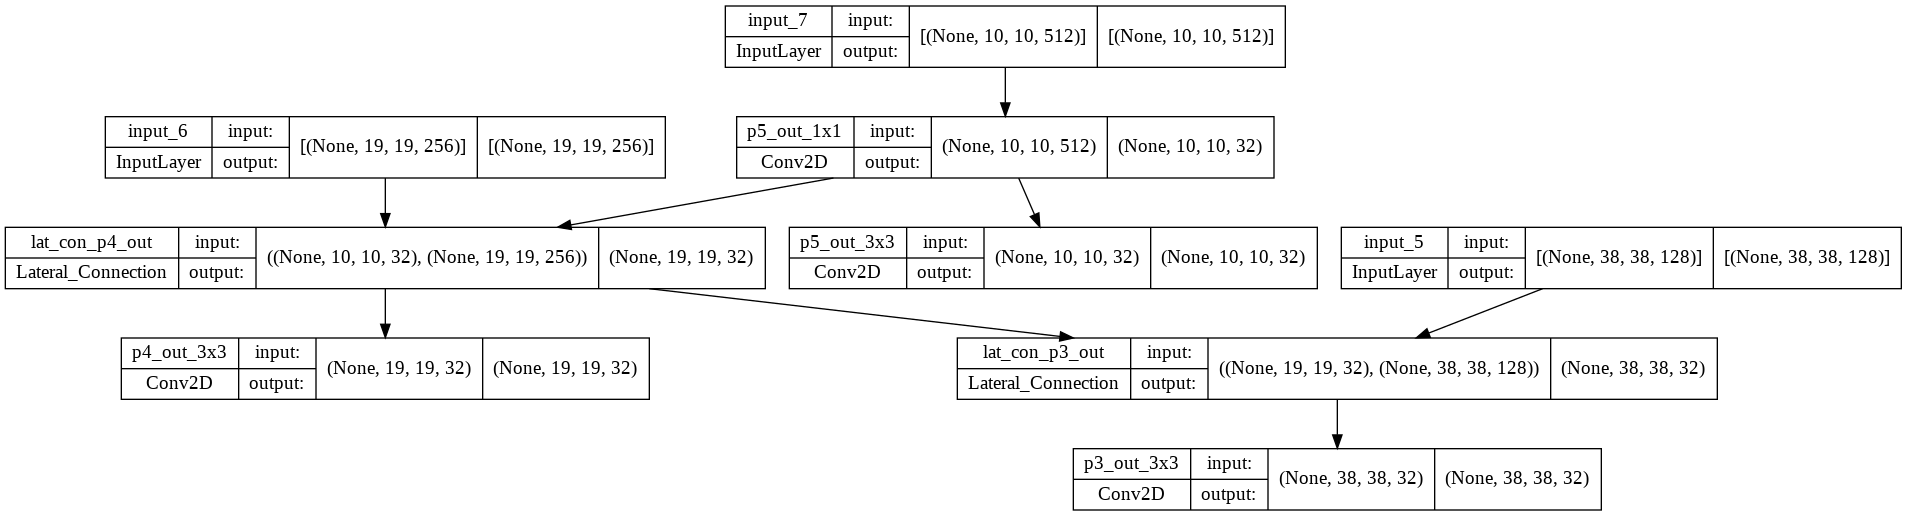

In [ ]:
# Get the FPN model
fpn_model = get_fpn(backbone_out=(layer_3_out, layer_4_out, layer_5_out), channels_out=32)
# Plot the FPN model
tf.keras.utils.plot_model(fpn_model, to_file='fpn.png', show_shapes=True, rankdir='TB')

**If you are wondering what `Lateral_Connection` class forward does with its two inputs, it does the following:**

It resizes lower resolution input (1st) to higher resolution input (2nd), passes higher resolution input to a conv2d layer to change its output channel, and then adds both and returns.

For example, for the following inputs:
```
(None, 19,19, 32), (None, 38, 38, 128)
```
The first input`(None, 19,19, 32)` is resized to `(None, 38,38, 32)`.

The second input `(None, 38,38, 128)` passes through conv2d that outputs `(None, 38,38, 32)`.

Then resized and conv2d output gets added, which shape results `(None, 38, 38, 32)`.


Have a look at the following code snippet from `fpn.py`.

```python
class Lateral_Connection(tf.keras.layers.Layer):
    def __init__(self, channels_out, **kwargs):
        super().__init__(**kwargs)
        self.conv_1x1 = tf.keras.layers.Conv2D(channels_out, 1, 1, "same")

    def call(self, inputs):
        # we use tf.image.resize instead of UpSampling2D because UpSampling2D requires int type scale params,
        # but in some cases we need to interpolate to some given size where current.shape/up.shape!=2
        # for example: we need to interpolate this one [1, 10, 10, 64] to this [1, 19, 19, 64]
        prev, current = inputs
        fm_size = tf.shape(current)[1:3]
        up = tf.image.resize(prev, size=fm_size, method="lanczos5", antialias=True)
        current = self.conv_1x1(current)
        x = up + current
        return x
```

## 3 A Sample Inference

Here are examples of two images that we have already downloaded.

<table><tr>
<td><img src="https://learnopencv.com/wp-content/uploads/2021/08/img1_bbox.png" align = 'middle' alt="Drawing" style="width: 400px;"></td>
<td><img src="https://learnopencv.com/wp-content/uploads/2021/08/img2_bbox.png" align = 'middle' alt="Drawing" style="width: 400px;"></td>
</tr></table>

Let's have inference.

In [ ]:
import cv2

img1 = cv2.imread("./test_images/FudanPed00001.png")
img2 = cv2.imread("./test_images/FudanPed00002.png")

img1 = tf.convert_to_tensor(cv2.resize(img1, (300, 300)) / 255., dtype = tf.float32)
img2 = tf.convert_to_tensor(cv2.resize(img2, (300, 300)) / 255., dtype = tf.float32)

images = tf.convert_to_tensor([img1, img2])

# Already initialized the detector model. Now let's predict
preds = detector.predict(images)

print('location_pred size: {}'.format(preds[0].shape))
print('class_pred size: {}'.format(preds[1].shape))

location_pred size: (2, 17451, 4)
class_pred size: (2, 17451, 2)


- We got the output as expected. However, `17451` predictions seem to be very high. It is high because the predictions are coming from five layers of the model, and each layer's resolution represents the grid in the original image, and each grid cell has nine anchors.

- All these predictions are relative to anchors means these are encoded predictions. So for actual prediction, we need to decode it. And also need to apply NMS on it because multiple anchors can predict one object. We will see it in detail in the coming unit.

- Hence, output from the model is encoded, so the label also needs to be encoded. We will also see ground truth encoding in the coming unit. 

## References

Since, Resnet-18 is not available with `tf.keras.applications`, we have used the pretrained feature extractor from the resnet-18 model available at **Richard Xiao's** github repo: https://github.com/RichardXiao13/TensorFlow-ResNets